# Trabajo 2: Aspectos prácticos de las redes neuronales

En este segundo trabajo, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.optimizers import SGD
from keras import optimizers

import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Obtención de los datos y pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

#### **Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación **

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [3]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1**: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

#### Alistamiento de los datos

In [4]:
batch_size = 64
num_classes = 10
epochs = 20
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### Red de la actividad 1, que utiliza unidades sigmoid

In [5]:
model = Sequential()
model.add(Dense(512,activation="relu",input_shape=(784,)))
model.add(Dense(128,activation="sigmoid"))
model.add(Dense(64,activation="sigmoid"))
model.add(Dense(num_classes,activation="softmax"))

model.summary()

model.compile(loss="categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

history = model.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 476,490
Trainable params: 476,490
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 10s 203us/step - loss: 2.1978 - acc: 0.3564 - val_loss: 2.0448 - val_acc: 0.5315
Epoch 2/20
48000/48000 [==============================] - 9s 196us/step - loss:

##### Cuando se utilizan unidades de sigmoid se puede observar que la función de perdida arranca en un valor muy alto, talves es uno de los modelos que veremos con el punto de arranque mas alto en la loss, esto puede deberse a que con unidades sigmoid durante el entrenamiento mueren neuronas ya que sigmoid es un valor negativo, sin embargo en los datos en train y los de validación los resultados no difieren notoriamente, adicionalmente el tiempo de entrenamiento puede ser bastante alto con respecto a los modelos que veremos.

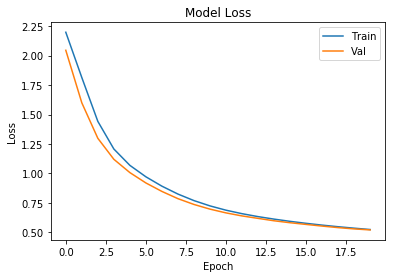

In [6]:
plot_loss(history, title="Model Loss")

##### Como se puede evidenciar en el plot de la función de perdida, el comportamiento del entrenamientos con ambos dataset tiene un comportamiento muy similar.

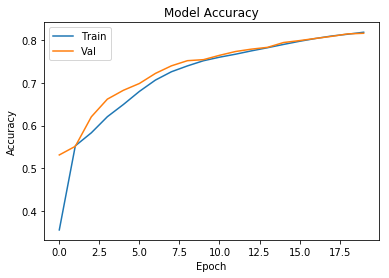

In [7]:
plot_acc(history, title="Model Accuracy")

In [12]:
#Red con unidades de activacion relu
model1 = Sequential()
model1.add(Dense(512,activation="relu",input_shape=(784,)))
model1.add(Dense(128,activation="relu"))
model1.add(Dense(96,activation="relu"))
model1.add(Dense(96,activation="relu"))
model1.add(Dense(num_classes,activation="softmax"))

model1.summary()
model1.compile(loss="categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

history1 = model1.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_12 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_13 (Dense)             (None, 96)                9312      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                970       
Total params: 490,250
Trainable params: 490,250
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 9s 190us/step - loss: 1.0065

#### Si entrenamos la red con unidades relu en su totalidad, 3 capas ocultas y 128 neuronas en cada capa, podemos observar que los resultados en tiempos, loss y accuracy mejoran mucho con respecto a la red anterior, una de las causas puede ser porque las unidades relu al ser positivas tienen menor muerte de neuronas de manera que hay mas participación por parte de estas.

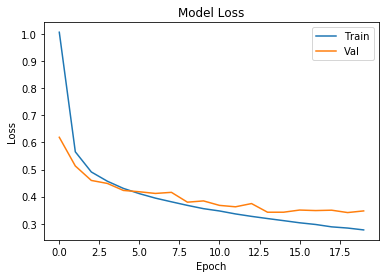

In [13]:
plot_loss(history1, title="Model Loss")

#### En la gráfica anterior, para el modelo entrenado con unidades relu, podemos ver una caída bastante notoria para la rate learning que podría mejorarse si regularizamos el modelo, tambien se observa que el entrenamiento para los datos de validación presenta un comportamiento diferente a los datos de train.

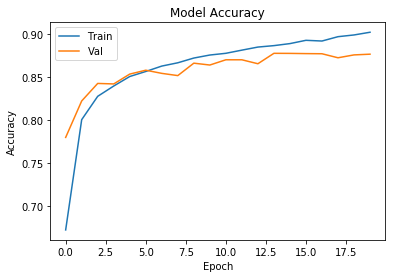

In [14]:
plot_acc(history1, title="Model Accuracy")

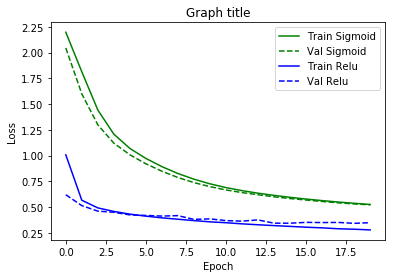

In [15]:
plot_compare_losses(history, history1, name1="Sigmoid",
                        name2="Relu", title="Graph title")

##### Los resultados de la red con unidades de activación relu son mucho mejores que el de las sigmoid

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2**: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

In [17]:
#Red con los parámetros en ceros.
model2 = Sequential()
model2.add(Dense(512,kernel_initializer='zeros',bias_initializer='zeros',activation='relu',input_shape=(784,)))
model2.add(Dense(128,kernel_initializer='zeros',bias_initializer='zeros',activation='relu'))
model2.add(Dense(96,kernel_initializer='zeros',bias_initializer='zeros',activation='relu'))
model2.add(Dense(96,kernel_initializer='zeros',bias_initializer='zeros',activation='relu'))
model2.add(Dense(num_classes,activation="softmax"))

model2.summary()

model2.compile(loss="categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

history2 = model2.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_22 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_23 (Dense)             (None, 96)                9312      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                970       
Total params: 490,250
Trainable params: 490,250
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 9s 180us/step - loss: 2.3026

#### Entrenando la red con los parámetros en ceros, como se puede observar la red cae en overfitting ya que todas las neuronas tiene la misma salida y el modelo no sería nada útil, la función de pérdida siempre se mantuvo y no hubo una mejora en el accuracy.

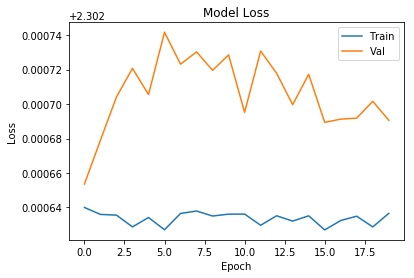

In [18]:
plot_loss(history2, title="Model Loss")

#### Como se puede ver en la gráfica, para el caso de la red con sus parámetros iniciados en ceros, el modelo intentó aprender pero caia nuevamente en el mismo ciclo, sin embargo los picos se ven mucho mas reflejados en los datos de validación.

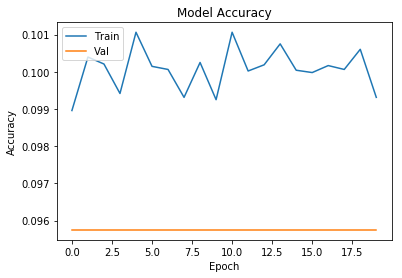

In [19]:
plot_acc(history2, title="Model Accuracy")

#### Para el caso del accuracy, se pueden ver mas los efectos en los datos de validación por ser mas pocos, el modelo no es nada apto

In [20]:
## Tu código y comentarios de texto aquí
model3 = Sequential()
model3.add(Dense(512,kernel_initializer=keras.initializers.RandomNormal(0, stddev=0.05),bias_initializer=keras.initializers.RandomNormal(0, stddev=0.05),activation='relu',input_shape=(784,)))
model3.add(Dense(128,kernel_initializer=keras.initializers.RandomNormal(0, stddev=0.05),bias_initializer=keras.initializers.RandomNormal(0, stddev=0.05),activation='relu'))
model3.add(Dense(96,kernel_initializer=keras.initializers.RandomNormal(0, stddev=0.05),bias_initializer=keras.initializers.RandomNormal(0, stddev=0.05),activation='relu'))
model3.add(Dense(num_classes,activation="softmax"))

model3.summary()
model3.compile(loss="categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

history3 = model3.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_27 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_28 (Dense)             (None, 10)                970       
Total params: 480,938
Trainable params: 480,938
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 9s 191us/step - loss: 1.0831 - acc: 0.6609 - val_loss: 0.6571 - val_acc: 0.7758
Epoch 2/20
48000/48000 [==============================] - 9s 187us/step - loss: 

##### Inicializando los parámetros con valores aleatorios, el entrenamiento de la red es mucho mejor en sus resultados, se esta rompiendo la simetría lo que permite que la red no caiga en overfitting así mismo estamos logrando que la red aprenda porque logramos que los gradientes sean distintos, aunque los parámetros en los datos de validación difieren bastante en los de train.

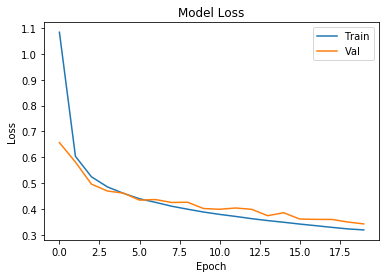

In [21]:
plot_loss(history3, title="Model Loss")

##### En la figura podemos observar una caída muy notoria en el entrenamiento, para resolverlo podriamos optimizar la red

In [22]:
model4 = Sequential()
model4.add(Dense(512,kernel_initializer=keras.initializers.glorot_uniform(seed=None),bias_initializer=keras.initializers.glorot_uniform(seed=None),activation='relu',input_shape=(784,)))
model4.add(Dense(128,kernel_initializer=keras.initializers.glorot_uniform(seed=None),bias_initializer=keras.initializers.glorot_uniform(seed=None),activation='relu'))
model4.add(Dense(96,kernel_initializer=keras.initializers.glorot_uniform(seed=None),bias_initializer=keras.initializers.glorot_uniform(seed=None),activation='relu'))
model4.add(Dense(num_classes,activation="softmax"))

model4.summary()
model4.compile(loss="categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

history4 = model4.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_31 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_32 (Dense)             (None, 10)                970       
Total params: 480,938
Trainable params: 480,938
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 8s 175us/step - loss: 0.8897 - acc: 0.7192 - val_loss: 0.6012 - val_acc: 0.7781
Epoch 2/20
48000/48000 [==============================] - 9s 192us/step - loss: 

##### Los tiempos de entrenamiento iniciando los parámetros de la red con la función de xavier son muy altos, pero el entrenamiento tiene muy buenos resultados

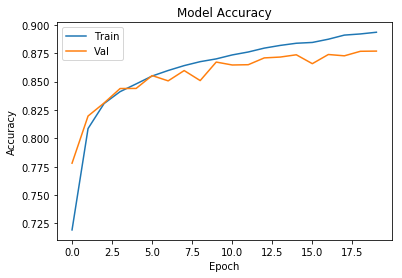

In [23]:
plot_acc(history4, title="Model Accuracy")

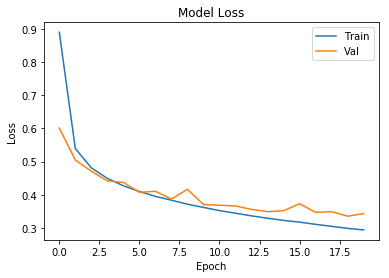

In [24]:
plot_loss(history4, title="Model Loss")

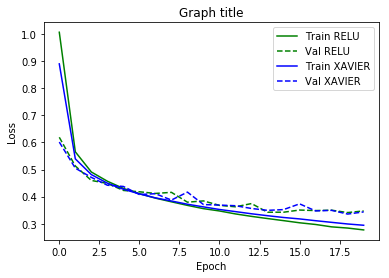

In [25]:
plot_compare_losses(history1, history4, name1="RELU",
                        name2="XAVIER", title="Graph title")

##### Hasta el momento, los mejores resultados son los presentasdos por las redes cuyos parámetros se han inicializado con xavier, y valores predeterminados de keras y con unidades relu.

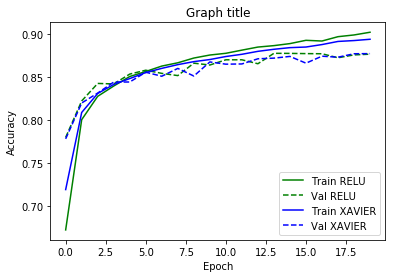

In [26]:
plot_compare_accs(history1, history4, name1="RELU",
                      name2="XAVIER", title="Graph title")

## 3. Optimizadores

**Ejercicio 3**: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

##### En mi concepto, la red que mejores resultados ha obtenido ha sido la model1, esta será la que usaré para los puntos restantes.

In [35]:
#optimizer RMSprop
#Red con unidades de activacion relu
model1RMS = Sequential()
model1RMS.add(Dense(512,activation="relu",input_shape=(784,)))
model1RMS.add(Dense(128,activation="relu"))
model1RMS.add(Dense(96,activation="relu"))
model1RMS.add(Dense(96,activation="relu"))
model1RMS.add(Dense(num_classes,activation="softmax"))

model1RMS.compile(loss="categorical_crossentropy",
             optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
             metrics=["accuracy"])

historylRMS = model1RMS.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 11s 220us/step - loss: 0.5654 - acc: 0.7918 - val_loss: 0.4498 - val_acc: 0.8293
Epoch 2/20
48000/48000 [==============================] - 10s 204us/step - loss: 0.3991 - acc: 0.8537 - val_loss: 0.3774 - val_acc: 0.8635
Epoch 3/20
48000/48000 [==============================] - 10s 211us/step - loss: 0.3607 - acc: 0.8689 - val_loss: 0.3699 - val_acc: 0.8681
Epoch 4/20
48000/48000 [==============================] - 12s 257us/step - loss: 0.3390 - acc: 0.8778 - val_loss: 0.3805 - val_acc: 0.8726
Epoch 5/20
48000/48000 [==============================] - 13s 270us/step - loss: 0.3238 - acc: 0.8832 - val_loss: 0.3695 - val_acc: 0.8694
Epoch 6/20
48000/48000 [==============================] - 12s 255us/step - loss: 0.3170 - acc: 0.8860 - val_loss: 0.3777 - val_acc: 0.8782
Epoch 7/20
48000/48000 [==============================] - 11s 232us/step - loss: 0.3108 - acc: 0.8891 - val_loss: 0.

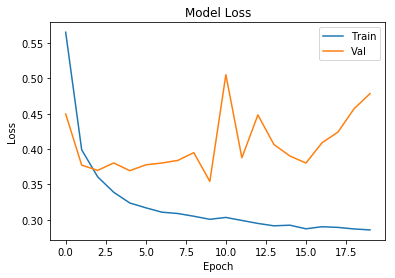

In [37]:
plot_loss(historylRMS, title="Model Loss")

##### Cuando usamos RMSprop, se puede observar que el accuracy esta muy cerca a 1, por lo tanto la red se debe regularizar.

In [38]:
#optimizer Adam
model1Adam = Sequential()
model1Adam.add(Dense(512,activation="relu",input_shape=(784,)))
model1Adam.add(Dense(128,activation="relu"))
model1Adam.add(Dense(96,activation="relu"))
model1Adam.add(Dense(96,activation="relu"))
model1Adam.add(Dense(num_classes,activation="softmax"))

model1Adam.compile(loss="categorical_crossentropy",
             optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
             metrics=["accuracy"])

history1Adam = model1Adam.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 13s 263us/step - loss: 0.5213 - acc: 0.8108 - val_loss: 0.4042 - val_acc: 0.8513
Epoch 2/20
48000/48000 [==============================] - 12s 247us/step - loss: 0.3775 - acc: 0.8603 - val_loss: 0.3763 - val_acc: 0.8622
Epoch 3/20
48000/48000 [==============================] - 12s 247us/step - loss: 0.3440 - acc: 0.8731 - val_loss: 0.3433 - val_acc: 0.8707
Epoch 4/20
48000/48000 [==============================] - 12s 258us/step - loss: 0.3137 - acc: 0.8829 - val_loss: 0.3334 - val_acc: 0.8783
Epoch 5/20
48000/48000 [==============================] - 13s 278us/step - loss: 0.2965 - acc: 0.8899 - val_loss: 0.3181 - val_acc: 0.8842
Epoch 6/20
48000/48000 [==============================] - 17s 356us/step - loss: 0.2779 - acc: 0.8968 - val_loss: 0.3314 - val_acc: 0.8876
Epoch 7/20
48000/48000 [==============================] - 14s 289us/step - loss: 0.2662 - acc: 0.8991 - val_loss: 0.

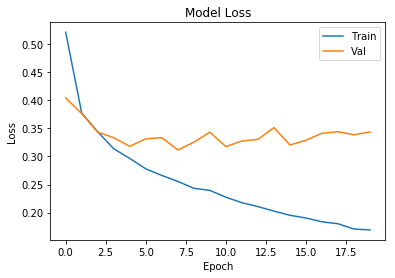

In [40]:
plot_loss(history1Adam, title="Model Loss")

In [41]:
#optimizer Adamax
model1Adamax = Sequential()
model1Adamax.add(Dense(512,activation="relu",input_shape=(784,)))
model1Adamax.add(Dense(128,activation="relu"))
model1Adamax.add(Dense(96,activation="relu"))
model1Adamax.add(Dense(96,activation="relu"))
model1Adamax.add(Dense(num_classes,activation="softmax"))
model1Adamax.compile(loss="categorical_crossentropy",
             optimizer=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
             metrics=["accuracy"])

history1Adamax = model1Adamax.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 13s 269us/step - loss: 0.5251 - acc: 0.8143 - val_loss: 0.4340 - val_acc: 0.8414
Epoch 2/20
48000/48000 [==============================] - 12s 248us/step - loss: 0.3787 - acc: 0.8626 - val_loss: 0.3777 - val_acc: 0.8585
Epoch 3/20
48000/48000 [==============================] - 12s 243us/step - loss: 0.3412 - acc: 0.8742 - val_loss: 0.3343 - val_acc: 0.8784
Epoch 4/20
48000/48000 [==============================] - 12s 245us/step - loss: 0.3125 - acc: 0.8844 - val_loss: 0.3370 - val_acc: 0.8797
Epoch 5/20
48000/48000 [==============================] - 13s 262us/step - loss: 0.2909 - acc: 0.8913 - val_loss: 0.3331 - val_acc: 0.8761
Epoch 6/20
48000/48000 [==============================] - 14s 296us/step - loss: 0.2757 - acc: 0.8972 - val_loss: 0.3291 - val_acc: 0.8814
Epoch 7/20
48000/48000 [==============================] - 15s 312us/step - loss: 0.2629 - acc: 0.9020 - val_loss: 0.

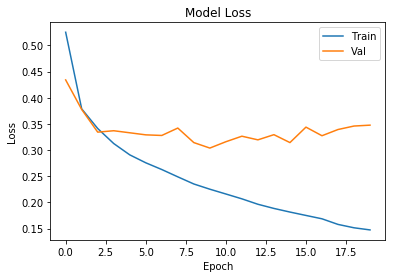

In [42]:
plot_loss(history1Adamax, title="Model Loss")

## 4. Regularización y red final

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

#### Durante en entrenamiento de las diferentes redes, observamos que los mejores resultados los vimos en el model1 la cual tenia los parámetros inicializados con los valores por defecto de keras y unidad de activación relu,  sin embargo cuando aplicamos regularización y optimización, los mejores resultados los obtenemos cuando inicializamos los parámetros con una distrubución normal.

In [59]:
modelFl = Sequential()
modelFl.add(Dense(512,kernel_initializer=keras.initializers.RandomNormal(0, stddev=0.05),bias_initializer=keras.initializers.RandomNormal(0, stddev=0.05),activation='relu',input_shape=(784,)))
modelFl.add(Dropout(0.2))
modelFl.add(Dense(128,kernel_initializer=keras.initializers.RandomNormal(0, stddev=0.05),bias_initializer=keras.initializers.RandomNormal(0, stddev=0.05),activation='relu'))
modelFl.add(Dropout(0.2))
modelFl.add(Dense(96,kernel_initializer=keras.initializers.RandomNormal(0, stddev=0.05),bias_initializer=keras.initializers.RandomNormal(0, stddev=0.05),activation='relu'))
modelFl.add(Dropout(0.2))
modelFl.add(Dense(num_classes,activation="softmax"))

modelFl.compile(loss="categorical_crossentropy",
             optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
             metrics=["accuracy"])

historyFl = modelFl.fit(x_train, y_train,
                   batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 400us/step - loss: 0.6014 - acc: 0.7853 - val_loss: 0.4052 - val_acc: 0.8504
Epoch 2/20
48000/48000 [==============================] - 20s 425us/step - loss: 0.4221 - acc: 0.8470 - val_loss: 0.3700 - val_acc: 0.8643
Epoch 3/20
48000/48000 [==============================] - 22s 467us/step - loss: 0.3816 - acc: 0.8616 - val_loss: 0.3687 - val_acc: 0.8663
Epoch 4/20
48000/48000 [==============================] - 17s 364us/step - loss: 0.3625 - acc: 0.8689 - val_loss: 0.3574 - val_acc: 0.8703
Epoch 5/20
48000/48000 [==============================] - 17s 358us/step - loss: 0.3420 - acc: 0.8747 - val_loss: 0.3369 - val_acc: 0.8772
Epoch 6/20
48000/48000 [==============================] - 16s 343us/step - loss: 0.3258 - acc: 0.8806 - val_loss: 0.3282 - val_acc: 0.8818
Epoch 7/20
48000/48000 [==============================] - 22s 459us/step - loss: 0.3159 - acc: 0.8835 - val_loss: 0.

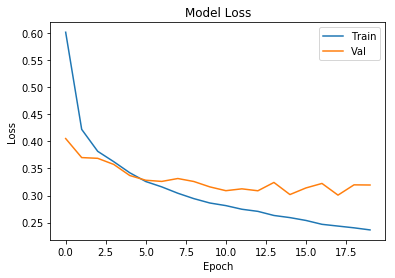

In [61]:
plot_loss(historyFl, title="Model Loss")

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [60]:
test_loss, test_acc = modelFl.evaluate(x_test,y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 2s 169us/step
Test accuracy: 0.8819


##### Como podemos observar, para el set de validación tenermos 12.000 registros, en el set de test tenemos 10.000 registros, nuestro modelo en la evaluación ha presentado una diferendia de 0.0099, lo que es aceptable.